The sources I used to learn Cross Correlation:
* https://liquidinstruments.com/blog/cross-correlation-and-spectrum-analysis/

* https://www.youtube.com/watch?v=cuD-LXic2cE


**markdown learn how to do the href thing**

Cross correlation is the measurement of how well two independent signals resemble each other, a concept known as cross-similarity.
Mathematically, cross-correlation is defined as the intergral of the product of two signals. One signal is given a time delay, T, and the cross-correlation is represented as a function of this time delay.

EX.
When two signals do not have any time overlap, the function is zero. Depending on whether the signals are of similar or opposite amplitudes, the correlation function cano also take on positive and negative values. 

**Signal analysis: Compare a incoming signal to a known template can detect events. 


In [94]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [95]:
rest_lines = np.array([5000.0, 6000.0, 6500.0])   # H‑beta, [O III], H‑alpha-ish placeholders
amps       = np.array([1.0,   0.8,   0.6])        # relative line strengths/

In [96]:
wl = np.linspace(4800, 9000, 7000)

# Guassian:
# w: an array of values. Represents the wavelength.
# w0: represents the center of the peak where Gaussian is tallest.
# amp: the amplitude of the peak
# sigma: a small sigma makes the peak narrow and steep. 
# big sigma makes it wide and smooth
def gaussian(w, w0, amp, sigma=3.0):
    """Simple Gaussian line profile"""
    return amp * np.exp(-(w - w0)**2 / (2.0 * sigma**2))

#Zeros_like returns an array of zeros 
# with the same shape and size as a

# Build rest‑frame template spectrum
template_flux = np.zeros_like(wl)
for w0, amp in zip(rest_lines, amps):
    template_flux += gaussian(wl, w0, amp)
indc =  np.where(template_flux!= 0 )


#print(template_flux[indc])
#print(w0)
#plt.figure(figsize=(10,4))
#plt.plot(wl, template_flux)

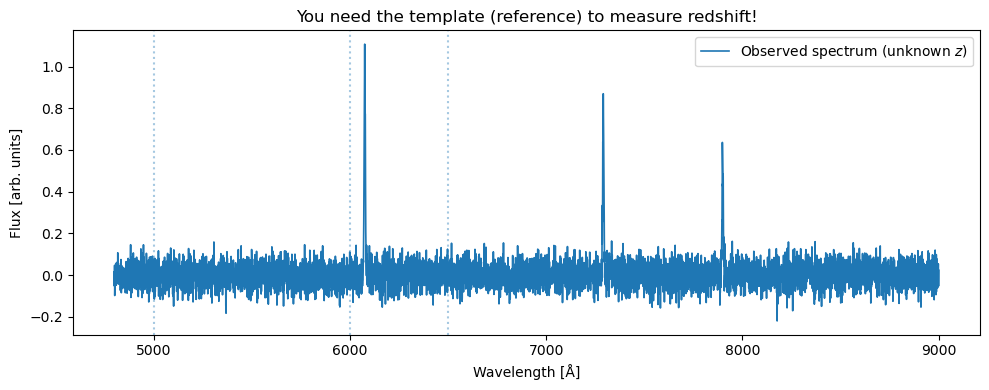

In [97]:
# ------------------------------------
# Apply a redshift to generate “data”
# ------------------------------------
z_true = np.random.uniform(0.0, 0.37)              # the unknown redshift we’ll try to recover
obs_lines = (1.0 + z_true) * rest_lines

observed_flux = np.zeros_like(wl)
for w0, amp in zip(obs_lines, amps):
    observed_flux += gaussian(wl, w0, amp)


# Add a touch of noise so it looks more realistic
rng = np.random.default_rng(42)
observed_flux += 0.05 * rng.normal(size=wl.size)

# ------------------------------------
# Plot: template vs. observed spectrum
# ------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux, label=f"Observed spectrum (unknown $z$)", linewidth=1.2)

    #plt.scatter(peaks, wl[peaks])
#plt.plot(wl, template_flux, '--', label="Template (rest‑frame)", linewidth=1.2)

# Mark the *rest* wavelengths (dotted) and observed wavelengths (dash‑dot)
for w_rest, w_obs in zip(rest_lines, obs_lines):
    plt.axvline(w_rest, linestyle=':', alpha=0.4)
    #plt.axvline(w_obs,  linestyle='-.', alpha=0.4)


plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [arb. units]")
plt.title("You need the template (reference) to measure redshift!")
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
from scipy.signal import correlate
from scipy.interpolate import interp1d
from scipy.signal import medfilt

In [ ]:

# Normalizing the spectrum to focus on shape.
def normalize_spectrum(flux):
    '''
        GOAL: Remove the continuum (the smooth background light) to emphasize
        absorption & emission lines... (Not really required for this simulated data, but I read it
        was good to consider when calculating redshift of real spectra...)
    '''

    #
    N = len(flux)

    kernel_fraction = 0.01 # 1% of the total length.. 
    
    # since our simulated len of flux is 7000 it will take the median of 70 points.
    kernel_size = int(N * kernel_fraction)

    # Make sure that the window size is odd, because without it no middle
    if N % 2 == 0:
        kernel_size += 1

    # Traces the curve, or 'shape' of the Spectrum... focusing on smoothing the hills instead of the peaks.
    continum = medfilt(flux, kernel_size)

    # Subtracting the continuum leaves me with just the sharp lines. 
    flux_no_continum = flux - continum
    return (flux_no_continum - np.mean(flux_no_continum)) / np.std(flux_no_continum)


* My method for above function:
    * At each point in $flux$, I am replacing that value with a median of neighboring points within defined indicies (or window size, also known as kernal_size). 
    * such, if I had an arr = [2, 2, 2, 15, 2] then taking the median would still give me 2. 
    * This would leave me with just the lines/features. This is why in the below plots the simulated data does not change, except for the placement of the mean.
    * 
    * Even after subtracting the continuum it might still have different scales based on how bright the source is. 
    * Basically, I want the spectrum to have a mean really close to 0 so that the focus is purely on the pattern of absoptions and emission lines. Also, I want it to behave like a 
    * 'unit vector' (vector of a fixed length). If both are unit vectors, then the cross correlation measures only their similarity. Not magnitude. 
    * Like comparing two shapes, not two brightnesses. 
    * This is important because Cross Correlation 'slides' the template over the 
    observed_flux to find where the pattern lines up best. Without normalization, brighter spectra dominate the correlation score even if their features dont line up well. 
        >(Which is why I was getting EXTREMELY off answers earlier.) (Also explains why my brute force method was really bad) 
    
    **add math in markdown later for more indepth explaination**

In [100]:
def shift_and_interpolate(wl, flux_temp, z):
    '''
        This function shifts the wavelength by an assumed redshift value and then plots the flux values based on the shift.
        My interpolate function maps any wavelength back to a flux value based on the template.
    '''
    shifted_wl = wl * (1 + z)
    interp_func = interp1d(shifted_wl, flux_temp, bounds_error=False, fill_value=0)
    return interp_func(wl)


In [101]:
# Normalized both observed_flux and the template.
observed_flux_normalized = normalize_spectrum(observed_flux)
normalized_flux = normalize_spectrum(template_flux)


#Verrry close to 0!
np.mean(observed_flux_normalized)

np.float64(4.06024420434343e-18)

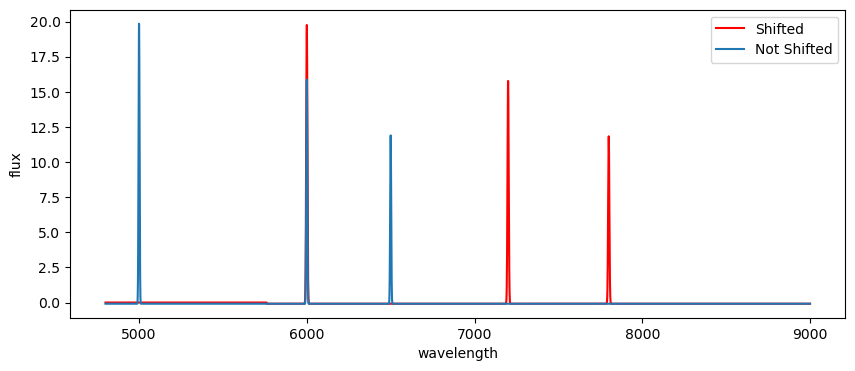

In [102]:
# Demonstrated here is the template shifted over by 0.2.
plt.figure(figsize=(10,4))
random_shifted = shift_and_interpolate(wl, normalized_flux, 0.2)
plt.plot(wl, random_shifted, color='r', label="Shifted")
plt.plot(wl, normalized_flux, label="Not Shifted")
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()

In [103]:
# Correlation. Described as below. the 'same' tag means that the output is the same as my input signal. Correlation is now centered. 
def compute_correlate(observed, shifted_temp):
    '''
        Correlation. Described as below. the 'same' tag means that the output is the same as my input signal. Correlation is now centered. 
        returns the highest correlation point in the array.
    '''
    return np.max(correlate(observed, shifted_temp, mode='same'))


The equation for Correlation is described as:

$$ r[m] = \sum_{n=0}^{N_1 + N_2 - 2}x_1[n]\space x_2[n+m] $$

This equation shifts the x_2 array over by 1 (adds it to the last index and moves up the 2nd in line) and r[m] is the sum  of every number in the x_1 array times it's indice in the x_2 array. Where it is the highest value is where it is most correlated. (Matches up the best)

The equation for the scipy Correlation:

$$ z[k] = \sum_{l = 0}^{N-1} x_l y_{l-k}^* $$

This matches (each piece) of how well x matches a shifted version of y. also has lag (like the shifted by 1 above) the * means a complex conjugate. pretty cool. Where x and y line up, z[k] will be a high value.

In [108]:
def calculate_redshift(assumed_redshifts, normalized_flux, observed_flux_normalized, wl):
    '''
        Takes every z value in the assumed redshifts, shifts the template with the rest_lines and gaussian to then cross correlate it with the observed spectrum. 
        It returns the scores (which is the cross correlation) and the redahift that has the highest cross correlation.
    '''
    scores = []
    for z in assumed_redshifts:
        shifted_temp = shift_and_interpolate(wl, normalized_flux, z)
        shifted_temp = normalize_spectrum(shifted_temp)
        score = compute_correlate(observed_flux_normalized, shifted_temp)    
        scores.append(score)
    
    return scores, assumed_redshifts[np.argmax(scores)]

In [105]:
def calculate_redshift_iterative(normalized_flux, observed_flux_normalized, wl, initial_pass, passes=3):
    '''
        Iteratively narrows down the best redshift.
    '''    
    # unpack the tuple
    z_min, z_max = initial_pass
    best_z = np.inf

    for i in range(passes):
        num_steps = 10000
        assumed_redshifts = np.linspace(z_min, z_max, num_steps)
        
        scores, best_z = calculate_redshift(assumed_redshifts, normalized_flux, observed_flux_normalized, wl)

        narrow = (z_max - z_min)/10
        z_min = max(best_z - narrow, 0)
        z_max = best_z + narrow
    
        print(f"Pass {i+1}: best_z = {best_z} in range {z_min} to {z_max}")

    return best_z, scores, assumed_redshifts

In [106]:
z_min = np.min(wl) / np.min(rest_lines) - 1
z_max = np.max(wl) / np.max(rest_lines) - 1
initial_pass = (z_min, z_max)

best_z, scores, redshifts_final = calculate_redshift_iterative(normalized_flux, observed_flux_normalized, wl, initial_pass)

print(f"The best redshift I found was {best_z}. The real redshift is {z_true}")

test = np.abs(redshifts_final - z_true)
indc = np.argmin(test)
print(f"The closest redshift found in the array was {redshifts_final[indc]}")

Pass 1: best_z = 0.21521936809065517 in range 0.1727578296291167 to 0.2576809065521936
Pass 2: best_z = 0.21521512151215116 in range 0.20672281381984348 to 0.22370742920445885
Pass 3: best_z = 0.21521257356504875 in range 0.2135141120265872 to 0.21691103510351029
The best redshift I found was 0.21521257356504875. The real redshift is 0.21520354914581044
The closest redshift found in the array was 0.21520408040804076


Text(0, 0.5, 'The scores of the reshifts in final pass.')

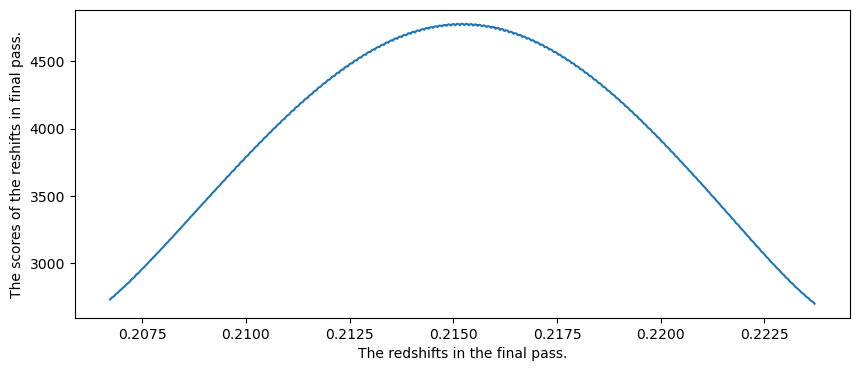

In [107]:
plt.figure(figsize=(10,4))
plt.plot(redshifts_final, scores)
plt.xlabel('The redshifts in the final pass.')
plt.ylabel('The scores of the reshifts in final pass.')